In [5]:
import numpy as np
import pandas as pd
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from prettytable import PrettyTable

In [6]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [7]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)
    return image_list,y_list

In [8]:
dirpath = 'SMAI-Dataset-release/IIIT-CFW/'
X,y = load_data(dirpath)
glob_y=y

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


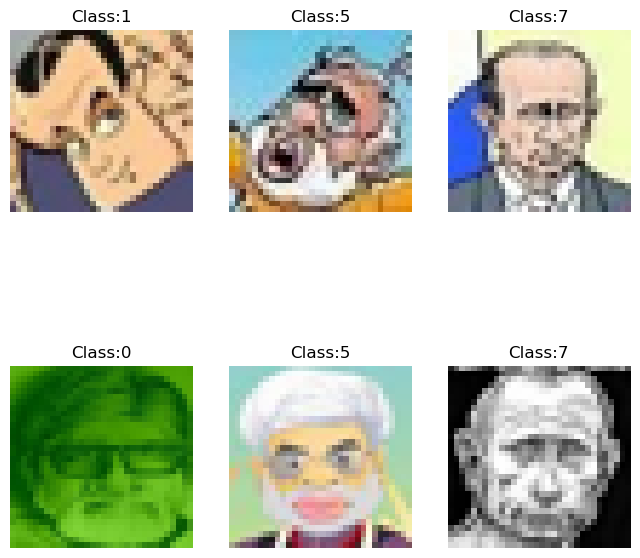

In [9]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

In [10]:
class PCA:
    def __init__(self,n_comps,m_comps):
        self.n_comps=n_comps
        self.max_comps=m_comps
        self.eig_val=None
        self.eig_vec=None
        self.flag=False
        if(n_comps>m_comps):
            print("Error!")
    def set_n_comps(self,new_n_comps):
        self.n_comps=new_n_comps
    def print_var(self,cum_var):
        x=[i for i in range(1,self.max_comps+1)]
        plt.plot(x,cum_var)
        plt.xlabel('No. of Principal Components')
        plt.ylabel('Cumulative Variance (%)')
        plt.title('Number of Principal Components vs Cumulative Explained Variance')
        plt.show()
    def get_orig_dim(self,X):
        X=X.T
        row_means=np.mean(X,axis=1,keepdims=True)
        X=X-row_means
        if self.flag==False:
            self.flag=True
            cov_matrix=np.cov(X)
            eig_val, eig_vec = np.linalg.eig(cov_matrix)
            indices = np.arange(0,len(eig_val), 1)
            indices = ([x for _,x in sorted(zip(eig_val, indices))])[::-1]
            self.eig_val = eig_val[indices]
            self.eig_vec = eig_vec[:,indices]
        eig_val=self.eig_val
        eig_vec=self.eig_vec
        sum_eig_val = np.sum(eig_val)
        explained_variance = eig_val/ sum_eig_val
        cumulative_variance = np.cumsum(explained_variance)
        cumulative_variance=np.real(cumulative_variance)
        self.print_var(cumulative_variance*100)
        feature_vec=eig_vec[:,:self.n_comps]
        cross_pdt=feature_vec.T@X
        orig_dt=(feature_vec@cross_pdt)+row_means
        real_part=np.real(orig_dt)
        real_part=real_part.T
        temp = real_part.reshape(672, 1024, 3)
        stacked_data = np.stack((temp,), axis=-1)
        final = stacked_data.reshape(672, 32, 32, 3)
        return final
    def fit_transform(self,X):
        X=X.T
        row_means=np.mean(X,axis=1,keepdims=True)
        X=X-row_means
        if self.flag==False:
            self.flag=True
            cov_matrix=np.cov(X)
            eig_val, eig_vec = np.linalg.eig(cov_matrix)
            indices = np.arange(0,len(eig_val), 1)
            indices = ([x for _,x in sorted(zip(eig_val, indices))])[::-1]
            self.eig_val = eig_val[indices]
            self.eig_vec = eig_vec[:,indices]
        eig_val=self.eig_val
        eig_vec=self.eig_vec
        feature_vec=eig_vec[:,:self.n_comps]
        cross_pdt=feature_vec.T@X
        return np.real(cross_pdt.T)

#### Performing Dimensionality Reduction on given Image dataset

In [11]:
temp=[]
for a in X:
    a=a.reshape(-1,3)
    a=a.reshape(-1)
    temp.append(a)
X=np.array(temp)

In [12]:
pca=PCA(300,X.shape[1])
X_new=pca.fit_transform(X)
print(X_new)

[[ 15.8405491    3.93425953   0.20772359 ...   0.6094819    0.07729769
   -0.29303091]
 [ 12.15561698  12.70722811   0.47995098 ...  -0.16849723  -0.3779866
    0.11140881]
 [  3.1718456   -1.14630423  -1.16145667 ...  -0.10517542   0.34826432
    0.11116163]
 ...
 [-10.27903264   0.87396374   0.7239614  ...   0.28926819   0.10386478
   -0.32405591]
 [  1.40198237  -3.01106201   1.51081605 ...  -0.11738743   0.11291528
    0.19560346]
 [ -6.78694849  -2.43310135   1.55211093 ...   0.02131629   0.05701753
    0.31954289]]


#### Reconstructing images from original data after PCA

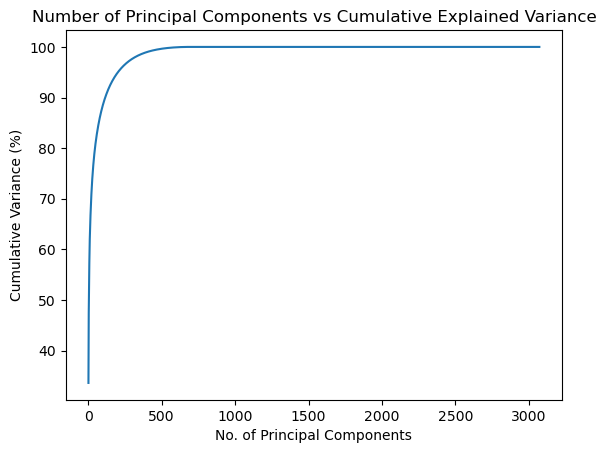

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


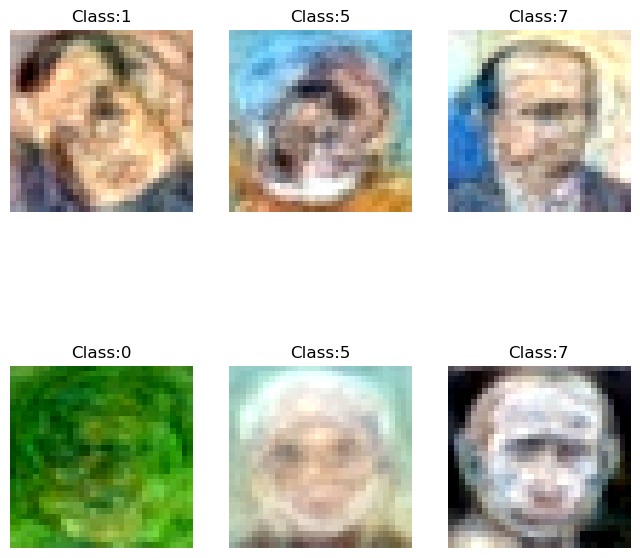

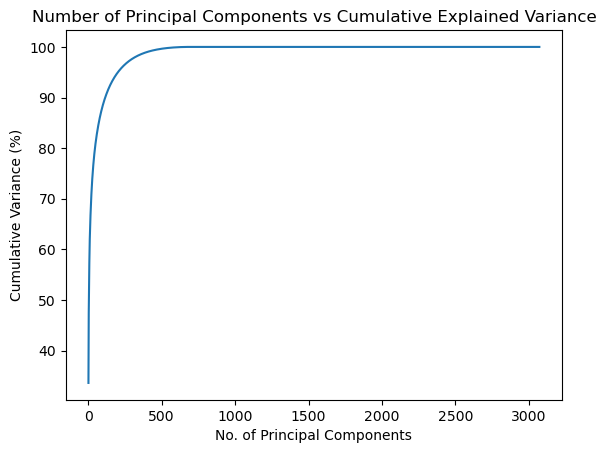

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


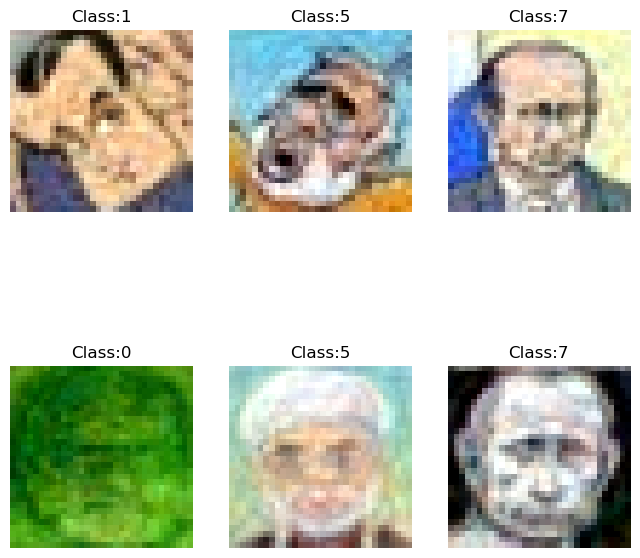

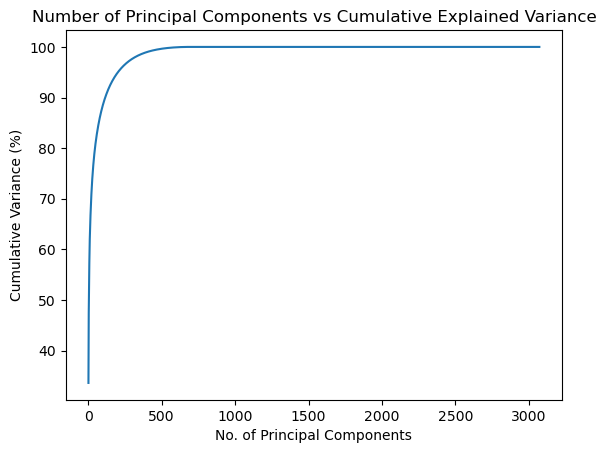

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


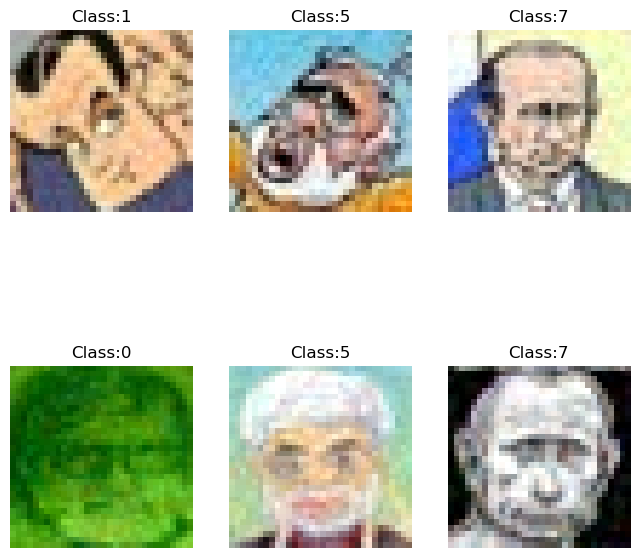

In [13]:
for x in [100,200,300]:
    pca=PCA(x,X.shape[1])
    x_new=pca.get_orig_dim(X)
    display_images(x_new[ind,...],y[ind], row=2,col=3)

### PCA on pictionary (Assignment-1) dataset

In [14]:
pic_data=np.load('data.npy',allow_pickle=True)
vit_data=pic_data[:,2]
vit_data=np.array([x[0] for x in vit_data]).reshape(1500,-1)
res_data=pic_data[:,1]
res_data=np.array([x[0] for x in res_data]).reshape(1500,-1)
true_y=pic_data[:,3]

#### Using VIT Embeddings

##### Before PCA

In [22]:
x_train, x_test, y_train, y_test = train_test_split(vit_data, true_y, test_size=0.2, random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors=11)
knn_classifier.fit(x_train, y_train)
y_pred = knn_classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='macro',zero_division=1)
recall = recall_score(y_test, y_pred,average='macro',zero_division=1)
f1_macro = f1_score(y_test, y_pred,average='macro')
table = PrettyTable()
table.field_names = ["Metric", "Value"]
table.add_row(["Accuracy",accuracy])
table.add_row(["Precision",precision])
table.add_row(["Recall",recall])
table.add_row(["F1 Score (Macro)",f1_macro])
print(table)

+------------------+---------------------+
|      Metric      |        Value        |
+------------------+---------------------+
|     Accuracy     |         0.23        |
|    Precision     |  0.5022735525186506 |
|      Recall      | 0.29758273679842306 |
| F1 Score (Macro) | 0.13321027592259305 |
+------------------+---------------------+


/Users/akshitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


##### After PCA

/Users/akshitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/akshitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

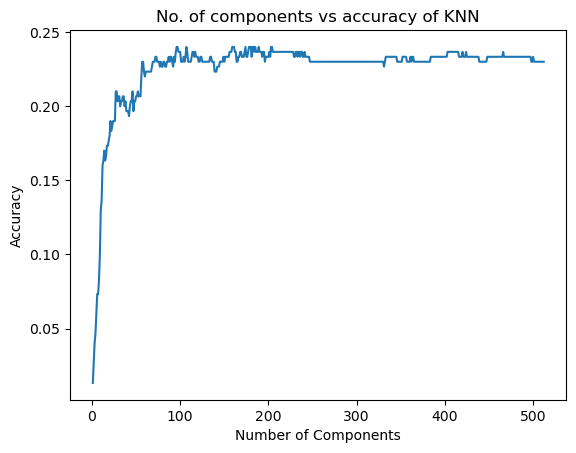

In [23]:
acc=[]
n_comps=[]
for i in range(1,vit_data.shape[1]+1):
    n_comps.append(i)
    pca=PCA(i,vit_data.shape[1])
    vit_data_pca=pca.fit_transform(vit_data)
    x_train, x_test, y_train, y_test = train_test_split(vit_data_pca, true_y, test_size=0.2, random_state=42)
    knn_classifier = KNeighborsClassifier(n_neighbors=11)
    knn_classifier.fit(x_train, y_train)
    y_pred = knn_classifier.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    acc.append(accuracy)
    precision = precision_score(y_test, y_pred,average='macro',zero_division=1)
    recall = recall_score(y_test, y_pred,average='macro',zero_division=1)
    f1_macro = f1_score(y_test, y_pred,average='macro')
    # table = PrettyTable()
    # table.field_names = ["Metric", "Value"]
    # table.add_row(["Accuracy",accuracy])
    # table.add_row(["Precision",precision])
    # table.add_row(["Recall",recall])
    # table.add_row(["F1 Score (Macro)",f1_macro])
    # print(table)
plt.plot(n_comps,acc)
plt.xlabel("Number of Components")
plt.ylabel("Accuracy")
plt.title("No. of components vs accuracy of KNN")
plt.show()

#### Observations: The accuracy values for different number of features does not follow a particular trend. However, the values do increase for smaller number of principal components (around 80-150 features in dataset). For larger number of features, they converge to the values we obtain for all features in dataset.

### Classification (Pre and Post PCA comparison)

#### Pre-Dimensionality Reduction

In [17]:
x=X
x_train,x_test,y_train,y_test=train_test_split(X,glob_y,test_size=0.2,random_state=42)
classifier=KNeighborsClassifier(n_neighbors=10)
classifier=classifier.fit(x_train,y_train)
pred=classifier.predict(x_test)
acc=accuracy_score(y_test,pred)
print(acc)

0.37777777777777777


/Users/akshitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


#### Post-Dimensionality Reduction (PCA)

/Users/akshitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/akshitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

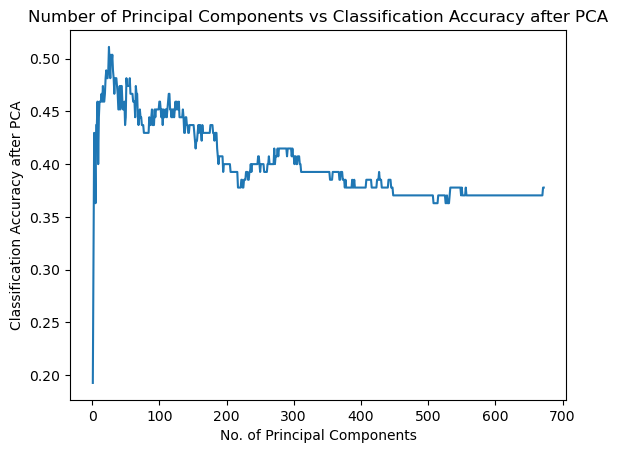

In [18]:
acc_arr=[]
temp_y=[]
pca=PCA(1,x.shape[1])
for i in range(1,673):
    temp_y.append(i)
    pca.set_n_comps(i)
    X_new=pca.fit_transform(X)
    x_train,x_test,y_train,y_test=train_test_split(X_new,glob_y,test_size=0.2,random_state=42)
    classifier=KNeighborsClassifier(n_neighbors=10)
    classifier=classifier.fit(x_train,y_train)
    pred=classifier.predict(x_test)
    acc=accuracy_score(y_test,pred)
    acc_arr.append(acc)
plt.plot(temp_y,acc_arr)
plt.xlabel('No. of Principal Components')
plt.ylabel('Classification Accuracy after PCA')
plt.title('Number of Principal Components vs Classification Accuracy after PCA')
plt.show()

#### Observations: The value of accuracy is maximum for number of components between 100-150. After that, it decreases and starts to resemble the accuracy we got without PCA (for all features).

### 1.2 Pictionary Dataset (Drawer and Guesser)

#### Loading the datasets and removing samples with all attributes 0

In [19]:
drawer_data=pd.read_csv('drawer_attributes.csv')
drawer_data = drawer_data[(drawer_data.iloc[:,1:] != 0).any(axis=1)]
drawer_data=drawer_data.iloc[:,1:].values
guesser_data=pd.read_csv('guesser_attributes.csv')
guesser_data=guesser_data[(guesser_data.iloc[:,1:] != 0).any(axis=1)]
guesser_data=guesser_data.iloc[:,1:].values

#### PCA on Drawer Dataset

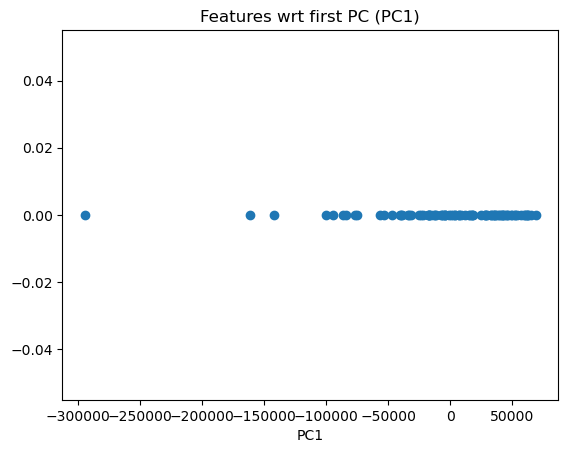

(84, 2)


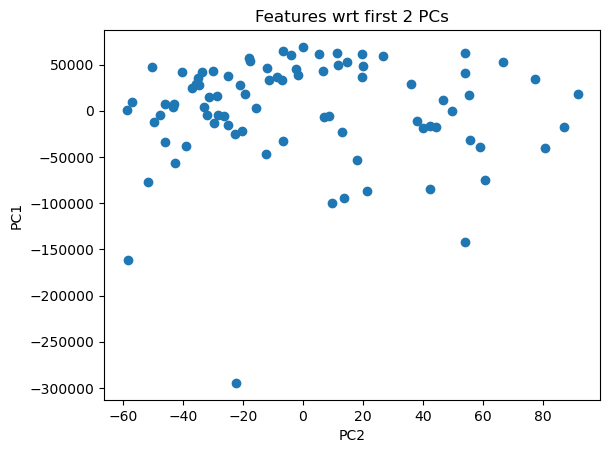

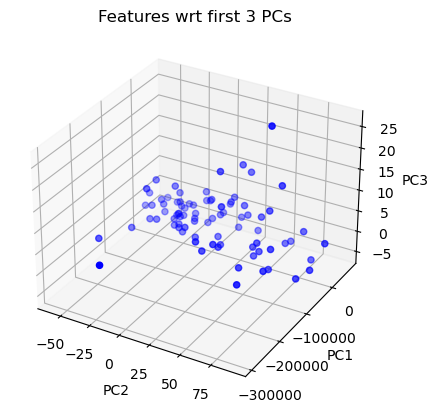

In [20]:
pc=PCA(1,drawer_data.shape[1])
drawer_new=pc.fit_transform(drawer_data)
plt.scatter(drawer_new,[0]*len(drawer_new))
plt.xlabel('PC1')
plt.ylabel('')
plt.title('Features wrt first PC (PC1)')
plt.show()
pc=PCA(2,drawer_data.shape[1])
drawer_new=pc.fit_transform(drawer_data)
print(drawer_new.shape)
x=[x[1] for x in drawer_new]
y=[x[0] for x in drawer_new]
plt.scatter(x,y)
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.title('Features wrt first 2 PCs')
plt.show()
pc=PCA(3,drawer_data.shape[1])
drawer_new=pc.fit_transform(drawer_data)
x=[x[1] for x in drawer_new]
y=[x[0] for x in drawer_new]
z=[x[2] for x in drawer_new]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o')
ax.set_xlabel('PC2')
ax.set_ylabel('PC1')
ax.set_zlabel('PC3')
ax.set_title('Features wrt first 3 PCs')
plt.show()


#### Each principal component represents a linear combination of the original features, and these components are orthogonal to each other, meaning they are uncorrelated. The principal components are ordered in such a way that the first component explains the most variance in the data, the second component explains the second most variance, and so on. Since the cumulative variance is almost 100% after the first principal component, we can say that there is a correlation between the attributes which allows us to represent all of them using only 1 new attribute (along the first PC i.e. PC1).

#### PCA on Guesser Dataset

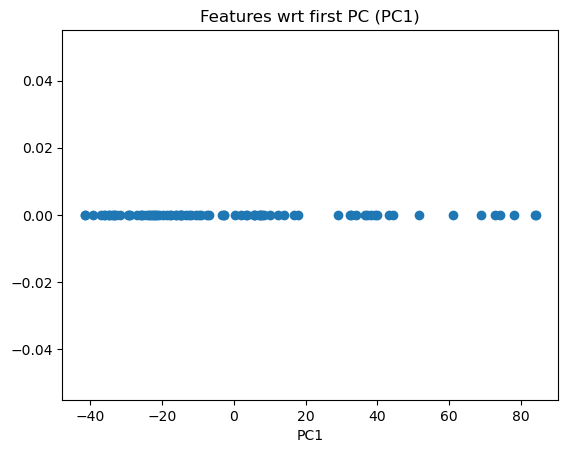

(86, 2)


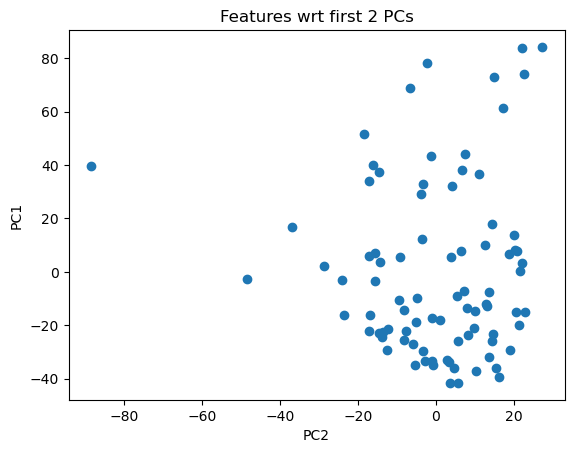

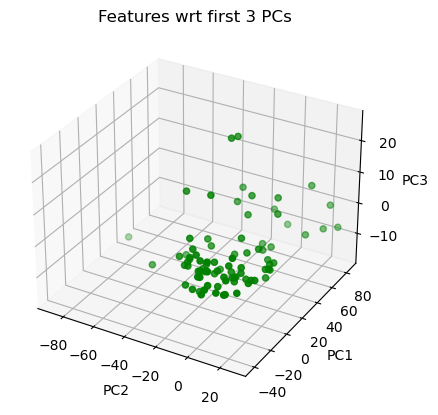

In [21]:
pc=PCA(1,guesser_data.shape[1])
guesser_new=pc.fit_transform(guesser_data)
plt.scatter(guesser_new[:,0],[0]*len(guesser_new))
plt.xlabel('PC1')
plt.ylabel('')
plt.title('Features wrt first PC (PC1)')
plt.show()
pc=PCA(2,guesser_data.shape[1])
guesser_new=pc.fit_transform(guesser_data)
print(guesser_new.shape)
x=[x[1] for x in guesser_new]
y=[x[0] for x in guesser_new]
plt.scatter(x,y)
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.title('Features wrt first 2 PCs')
plt.show()
pc=PCA(3,guesser_data.shape[1])
guesser_new=pc.fit_transform(guesser_data)
x=[x[1] for x in guesser_new]
y=[x[0] for x in guesser_new]
z=[x[2] for x in guesser_new]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='g', marker='o')
ax.set_xlabel('PC2')
ax.set_ylabel('PC1')
ax.set_zlabel('PC3')
ax.set_title('Features wrt first 3 PCs')
plt.show()

#### Each principal component represents a linear combination of the original features, and these components are orthogonal to each other, meaning they are uncorrelated. The principal components are ordered in such a way that the first component explains the most variance in the data, the second component explains the second most variance, and so on. Since the cumulative variance is almost 100% after the first 3 principal components, we can say that there is a correlation between the attributes which allows us to represent all of them using only 3 new uncorrelated attributes (along the first 3 PCs).